# Simulate Race

## Settings

In [42]:
# set simulation parameters
RESULTS_DIR = "/content/gdrive/MyDrive/RLF002/vse-005-from-realstrat/sim/Shanghai_2019_realstrat_50k"

RACE_PARAMS_FILE = "/content/racesim/input/parameters/pars_Shanghai_2019.ini"
MCS_PARAMS_FILE = "/content/racesim/input/parameters/pars_mcs.ini"

# set simulation options
NO_SIM_RUN = 10_000

sim_opts = {
    # use_prob_infl:        activates probabilistic influences within the race simulation -> lap times, pit stop
    #                       durations, race start performance
    "use_prob_infl": True,
    # create_rand_events:   activates the random creation of FCY (full course yellow) phases and retirements in the race
    #                       simulation -> they will only be created if the according entries in the parameter file
    #                       contain empty lists, otherwise the file entries are used
    "create_rand_events": True,
    # use_vse:              determines if the VSE (virtual strategy engineer) is used to take tire change decisions
    #                       -> the VSE type is defined in the parameter file (VSE_PARS)
    "use_vse": True,
    # no_sim_runs:          number of (valid) races to simulate
    "no_sim_runs": NO_SIM_RUN,
    # no_workers:           defines number of workers for multiprocess calculations, 1 for single process, >1 for
    #                       multi-process (you can use print(multiprocessing.cpu_count()) to determine the max. number)
    "no_workers": 1,
    # use_print:            set if prints to console should be used or not (does not suppress hints/warnings)
    "use_print": True,
    # use_print_result:     set if result should be printed to console or not
    "use_print_result": True,
    # use_plot:             set if plotting should be used or not
    "use_plot": False
}

vse_paths = {
    "reinf_nnmodel": "/content/gdrive/MyDrive/RLF002/vse-005-from-realstrat/exports/2023-05-23-final/nn_reinforcement_Shanghai_2019.tflite",
    "reinf_preprocessor": "/content/gdrive/MyDrive/RLF002/vse-005-from-realstrat/exports/2023-05-23-final/preprocessor_reinforcement_Shanghai_2019.pkl",
    # "reinf_nnmodel": "/content/racesim/input/vse/nn_reinforcement_Shanghai_2019.tflite",
    # "reinf_preprocessor": "/content/racesim/input/vse/preprocessor_reinforcement_Shanghai_2019.pkl",
    "supervised_nnmodel_cc": "/content/racesim/input/vse/nn_supervised_compoundchoice.tflite",
    "supervised_nnmodel_tc": "/content/racesim/input/vse/nn_supervised_tirechange.tflite",
    "supervised_preprocessor_cc": "/content/racesim/input/vse/preprocessor_supervised_compoundchoice.pkl",
    "supervised_preprocessor_tc": "/content/racesim/input/vse/preprocessor_supervised_tirechange.pkl"
}

# VSE type for other drivers: 'basestrategy', 'realstrategy', 'supervised', 'reinforcement'
vse_types = {
    "RIC": "reinforcement",
    "BOT": "reinforcement",
    "GAS": "reinforcement",
    "NOR": "reinforcement",
    "PER": "reinforcement",
    "LEC": "reinforcement",
    "VER": "reinforcement",
    "ALB": "reinforcement",
    "GIO": "reinforcement",
    "GRO": "reinforcement",
    "HAM": "reinforcement",
    "HUL": "reinforcement",
    "KUB": "reinforcement",
    "KVY": "reinforcement",
    "MAG": "reinforcement",
    "RAI": "reinforcement",
    "RUS": "reinforcement",
    "SAI": "reinforcement",
    "STR": "reinforcement",
    "VET": "reinforcement",
}

realstrategy = []
# realstrategy = ["RIC", "BOT", "GAS", "NOR", "PER", "LEC", "VER"]

Select some drivers to use real strategy

In [43]:
vse_types = {
    driver: "realstrategy" if driver in realstrategy else "reinforcement" 
    for driver, strategy in vse_types.items()
  }
vse_types

{'RIC': 'reinforcement',
 'BOT': 'reinforcement',
 'GAS': 'reinforcement',
 'NOR': 'reinforcement',
 'PER': 'reinforcement',
 'LEC': 'reinforcement',
 'VER': 'reinforcement',
 'ALB': 'reinforcement',
 'GIO': 'reinforcement',
 'GRO': 'reinforcement',
 'HAM': 'reinforcement',
 'HUL': 'reinforcement',
 'KUB': 'reinforcement',
 'KVY': 'reinforcement',
 'MAG': 'reinforcement',
 'RAI': 'reinforcement',
 'RUS': 'reinforcement',
 'SAI': 'reinforcement',
 'STR': 'reinforcement',
 'VET': 'reinforcement'}

Mount Google Drive.

In [3]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


Check Colab settings.

In [4]:
from psutil import virtual_memory

gpu_info = !nvidia-smi
gpu_info = "\n".join(gpu_info)
if gpu_info.find("failed") >= 0:
  print("Not connected to a GPU")
else:
  print(gpu_info)

ram_gb = virtual_memory().total / 1e9
print(f"Your runtime has {ram_gb:.1f} gigabytes of available RAM\n")

if ram_gb < 20:
  print("Not using a high-RAM runtime")
else:
  print("You are using a high-RAM runtime!")

/bin/bash: nvidia-smi: command not found
Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


## Installation

Install code repository

In [5]:
!git clone --depth 1 https://github.com/pezon/msca-race-simulation 
!cp -R msca-race-simulation/* .

Cloning into 'msca-race-simulation'...
remote: Enumerating objects: 366, done.
remote: Counting objects: 100% (366/366), done.
remote: Compressing objects: 100% (305/305), done.
remote: Total 366 (delta 176), reused 207 (delta 52), pack-reused 0
Receiving objects: 100% (366/366), 3.78 MiB | 15.88 MiB/s, done.
Resolving deltas: 100% (176/176), done.


Install dependencies.

In [6]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.5/113.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 45.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.0 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.23.0-py3-none-any.whl size=697644 sha256=86128fe45a4cd7d63ab21589c8208e38e843b10a5ea

## Initialization

Import libraries

In [44]:
from concurrent import futures  # required for parallel computing
import os
import pickle
import time
import warnings
from datetime import datetime
from pathlib import Path
from pprint import pprint

import numpy as np
from fastf1.plotting import setup_mpl

import racesim
import helper_funcs
from racesim.src.check_pars import check_pars
from racesim.src.import_pars import import_pars
from racesim.src.race_handle import race_handle
from racesim.src.mcs_analysis import mcs_analysis

warnings.filterwarnings("ignore")
setup_mpl(misc_mpl_mods=False)

run_id = datetime.today().strftime("%Y-%m-%d-%H-%M-%s")

# Set working directories
results_dir = Path(RESULTS_DIR)
run_dir = results_dir / "simulations" / run_id
results_dir = run_dir / "results"
invalid_dir = run_dir / "invalid"
samples_dir = run_dir / "samples"

# Create directories
results_dir.mkdir(exist_ok=True, parents=True)
invalid_dir.mkdir(exist_ok=True, parents=True)
samples_dir.mkdir(exist_ok=True, parents=True)

print(f"{results_dir=!s}")
print(f"{invalid_dir=!s}")
print(f"{samples_dir=!s}")

results_dir=/content/gdrive/MyDrive/RLF002/vse-005-from-realstrat/sim/Shanghai_2019_realstrat_50k/simulations/2023-05-25-20-37-1685047051/results
invalid_dir=/content/gdrive/MyDrive/RLF002/vse-005-from-realstrat/sim/Shanghai_2019_realstrat_50k/simulations/2023-05-25-20-37-1685047051/invalid
samples_dir=/content/gdrive/MyDrive/RLF002/vse-005-from-realstrat/sim/Shanghai_2019_realstrat_50k/simulations/2023-05-25-20-37-1685047051/samples


## Check parameters

Load and check parameters

In [45]:
# Load parameters
pars_in, _ = import_pars(
    use_print=sim_opts["use_print"],
    use_vse=False,  # sim_opts["use_vse"],
    race_pars_file=RACE_PARAMS_FILE,
    mcs_pars_file=MCS_PARAMS_FILE)

# Check parameters
racesim.src.check_pars.check_pars(
    sim_opts=sim_opts,
    pars_in=pars_in)

INFO: Loading race parameters...
INFO: Loading MCS parameters...
INFO: Checking user input...
HINT: Think about increasing the number of workers when simulating a big amount of races!
INFO: FCY phases for the race simulation were set as follows: [[0.818, 1.392, 'VSC', None, None]]
INFO: Retirements for the race simulation were set as follows: [['HUL', 16.5], ['KVY', 41.5], ['NOR', 50.5]]
INFO: Using VSE (virtual strategy engineer) to take tire change decisions!


VSE Settings

In [46]:
# Update VSE parameters
pars_in["vse_pars"]["vse_type"] = vse_types

print("VSE types:")
pprint(pars_in['vse_pars']['vse_type'])

print("VSE paths:")
pprint(vse_paths)

VSE types:
{'ALB': 'reinforcement',
 'BOT': 'reinforcement',
 'GAS': 'reinforcement',
 'GIO': 'reinforcement',
 'GRO': 'reinforcement',
 'HAM': 'reinforcement',
 'HUL': 'reinforcement',
 'KUB': 'reinforcement',
 'KVY': 'reinforcement',
 'LEC': 'reinforcement',
 'MAG': 'reinforcement',
 'NOR': 'reinforcement',
 'PER': 'reinforcement',
 'RAI': 'reinforcement',
 'RIC': 'reinforcement',
 'RUS': 'reinforcement',
 'SAI': 'reinforcement',
 'STR': 'reinforcement',
 'VER': 'reinforcement',
 'VET': 'reinforcement'}
VSE paths:
{'reinf_nnmodel': '/content/gdrive/MyDrive/RLF002/vse-005-from-realstrat/exports/2023-05-23-final/nn_reinforcement_Shanghai_2019.tflite',
 'reinf_preprocessor': '/content/gdrive/MyDrive/RLF002/vse-005-from-realstrat/exports/2023-05-23-final/preprocessor_reinforcement_Shanghai_2019.pkl',
 'supervised_nnmodel_cc': '/content/racesim/input/vse/nn_supervised_compoundchoice.tflite',
 'supervised_nnmodel_tc': '/content/racesim/input/vse/nn_supervised_tirechange.tflite',
 'supervis

Race parameters

In [47]:
pars_in["race_pars"]

{'season': 2019,
 'tot_no_laps': 56,
 'min_t_dist': 0.5,
 'min_t_dist_sc': 0.8,
 't_duel': 0.3,
 't_overtake_loser': 0.3,
 'use_drs': True,
 'drs_window': 1.0,
 'drs_allow_lap': 3,
 'drs_sc_delay': 2,
 'participants': ['HAM',
  'RIC',
  'MAG',
  'HUL',
  'KVY',
  'RAI',
  'VET',
  'BOT',
  'PER',
  'GRO',
  'SAI',
  'VER',
  'GIO',
  'STR',
  'GAS',
  'LEC',
  'NOR',
  'ALB',
  'RUS',
  'KUB']}

Track parameters

In [48]:
pars_in["track_pars"]

{'name': 'Shanghai',
 't_q': 91.547,
 't_gap_racepace': 1.812,
 't_lap_sens_mass': 0.031,
 't_pit_tirechange_min': 1.9,
 't_pitdrive_inlap': 4.881,
 't_pitdrive_outlap': 15.045,
 't_pitdrive_inlap_fcy': 2.512,
 't_pitdrive_outlap_fcy': 12.04,
 't_pitdrive_inlap_sc': 0.545,
 't_pitdrive_outlap_sc': 11.37,
 'pits_aft_finishline': True,
 't_loss_pergridpos': 0.139,
 't_loss_firstlap': 2.238,
 't_gap_overtake': 1.5,
 't_gap_overtake_vel': -0.037,
 't_drseffect': -0.553,
 'mult_t_lap_sc': 1.6,
 'mult_t_lap_fcy': 1.4}

Tire degradation parameters fitted to driver

In [49]:
pars_in["tireset_pars"]["LEC"]

{'tire_deg_model': 'lin',
 'mult_tiredeg_sc': 0.25,
 'mult_tiredeg_fcy': 0.5,
 't_add_coldtires': 1.0,
 'A3': {'k_0': 0.4731,
  'k_1_lin': 0.0963,
  'k_1_quad': 0.0937,
  'k_2_quad': 0.0002},
 'A4': {'k_0': 0.0, 'k_1_lin': 0.1501, 'k_1_quad': 0.1486, 'k_2_quad': 0.0001},
 'A6': {'k_0': 1.3218,
  'k_1_lin': 0.0367,
  'k_1_quad': 0.0323,
  'k_2_quad': 0.0003}}

Car/team parameters

In [50]:
pars_in["car_pars"]["Ferrari"]

{'drivetype': 'combustion',
 'manufacturer': 'Ferrari',
 't_car': 0.317,
 'm_fuel': 110.0,
 'b_fuel_perlap': 1.964,
 'energy': None,
 'energy_perlap': None,
 'mult_consumption_sc': 0.25,
 'mult_consumption_fcy': 0.5,
 'auto_consumption_adjust': True,
 't_pit_tirechange_add': 0.584,
 't_pit_refuel_perkg': None,
 't_pit_charge_perkwh': None,
 'color': '#DC0000',
 'p_failure': 0.086,
 't_pit_var_fisk_pars': [2.414, -0.153, 0.737]}

Driver parameters

In [51]:
pars_in["driver_pars"]["LEC"]

{'carno': 16,
 'name': 'Charles Leclerc',
 'initials': 'LEC',
 'team': 'Ferrari',
 't_driver': 0.0,
 'strategy_info': [[0, 'A4', 2, 0.0], [22, 'A3', 0, 0.0], [42, 'A4', 0, 0.0]],
 'p_grid': 4,
 't_teamorder': 0.0,
 'vel_max': 325.6,
 'p_accident': 0.058,
 't_lap_var_sigma': 0.533,
 't_startperf': {'mean': -0.042, 'sigma': 0.125}}

Race day events: full course yellow and retirements

In [52]:
pars_in["event_pars"]

{'fcy_data': {'phases': [[0.818, 1.392, 'VSC', None, None]],
  'domain': 'progress'},
 'retire_data': {'retirements': [['HUL', 16.5], ['KVY', 41.5], ['NOR', 50.5]],
  'domain': 'progress'}}

In [53]:
pars_in["monte_carlo_pars"]

{'min_dist_sc': 1.5,
 'min_dist_vsc': 1.5,
 'ref_driver': 'HAM',
 'p_sc_quant': [0.455, 0.413, 0.099, 0.033],
 'p_sc_start': [0.364, 0.136, 0.136, 0.08, 0.193, 0.091],
 'p_sc_duration': [0.0,
  0.182,
  0.25,
  0.227,
  0.193,
  0.057,
  0.068,
  0.023,
  0.0,
  0.0],
 'p_vsc_aft_failure': 0.227,
 'p_vsc_duration': [0.479, 0.396, 0.021, 0.104]}

## Simulate 

Uses single processor approach.

Run a single simulation

In [54]:
# create list containing the simulated race object (single run) or dicts with valid results (multiple runs)
sim_opts["no_sim_runs"] = 1
race_results = []

# save start time for runtime calculation
if sim_opts["use_print"]:
    print("INFO: Starting simulations...")
t_start = time.perf_counter()

# iteration variables
no_sim_runs_left = sim_opts["no_sim_runs"]  # counter for the number of races left for simulation
ctr_invalid = 0                             # counter for the number of simulated races marked as invalid

# SINGLE PROCESS ---------------------------------------------------------------------------------------------------
while no_sim_runs_left > 0:
    # simulate race
    race = race_handle(
        pars_in=pars_in,
        use_prob_infl=sim_opts["use_prob_infl"],
        create_rand_events=sim_opts["create_rand_events"],
        vse_paths=vse_paths)
    no_sim_runs_left -= 1

    # CASE 1: result is valid
    if race.result_status == 0:
        # save race object for later evaluation (single race) or simple race results (MCS)
        if sim_opts["no_sim_runs"] > 1:
            race_results.append(race.get_race_results())
        else:
            race_results.append(race)

    # CASE 2: result is invalid
    else:
        # increase no_sim_runs_left
        ctr_invalid += 1
        no_sim_runs_left += 1

        # pickle race object for further analysis
        if race.result_status >= 10 or race.result_status == -1:
            cur_time_str = time.strftime("%Y%m%d_%H%M%S")
            invalid_race_file = invalid_dir / f"{cur_time_str}_invalid_race_{ctr_invalid}_{race.result_status}.pkl"
            with open(invalid_race_file, "wb") as fh:
                pickle.dump(race, fh)

    # print progressbar
    if sim_opts["use_print"]:
        helper_funcs.src.progressbar.progressbar(
            i=sim_opts["no_sim_runs"] - no_sim_runs_left,
            i_total=sim_opts["no_sim_runs"],
            prefix="INFO: Simulation progress:")

# print number of invalid races
if sim_opts["use_print"]:
    print(f"INFO: There were {ctr_invalid} invalid races!")

# print runtime into console window
if sim_opts["use_print"]:
    runtime = time.perf_counter() - t_start
    print(f"INFO: Simulation runtime: {runtime:.3f}s ({runtime / sim_opts['no_sim_runs'] * 1000:.3f}ms per race)")

INFO: Starting simulations...
INFO: Simulation progress: |██████████████████████████████████████████████████| 100.0% 
INFO: There were 0 invalid races!
INFO: Simulation runtime: 0.409s (408.764ms per race)


In [55]:
# For a single race...
if sim_opts["no_sim_runs"] == 1:
    race_results[0].check_valid_result()

    if sim_opts["use_print_result"]:
        race_results[0].print_result()
        race_results[0].print_details()

    if sim_opts["use_plot"]:
        # race_results[0].plot_laptimes()
        # race_results[0].plot_positions()
        # race_results[0].plot_racetime_diffto_refdriver(1)
        # race_results[0].plot_raceprogress_over_racetime()

        # laps_simulated = race_results[0].cur_lap
        # t_race_winner = np.sort(race_results[0].racetimes[laps_simulated, :])[0]
        # race_results[0].plot_racetime_diffto_reflaptime(ref_laptime=t_race_winner / laps_simulated)
        pass

    # evaluation
    race_results[0].print_race_standings(racetime=2520.2)

    # save lap times, race times and positions to csv files
    race_results[0].export_results_as_csv(results_path=results_dir)

    # pickle race object for possible CI testing
    sample_file_path = samples_dir / f"testobj_racesim_{pars_in['track_pars']['name']}_{pars_in['race_pars']['season']}.pkl"
    with open(sample_file_path, "wb") as fh:
        pickle.dump(race_results[0], fh)

RESULT: Pre-simulation base strategy (by VSE) for HAM: [[0, 'A4', 2, 0.0], [1, 'A3', 0, 0.0], [15, 'A3', 0, 0.0], [40, 'A3', 0, 0.0]]
RESULT: Pre-simulation race duration for HAM: 5490.229s
RESULT: Simulation result:
     pos  carno   t_race    gap    int  best_t_lap  no_laps status                     strategy_info
BOT    1     77 5485.867  0.000  0.000      94.146       56      F             [0, 'A4'], [39, 'A3']
HAM    2     44 5487.622  1.754  1.754      95.396       56      F             [0, 'A4'], [23, 'A3']
VER    3     33 5492.852  6.984  5.230      95.480       56      F             [0, 'A4'], [28, 'A3']
LEC    4     16 5513.954 28.086 21.102      95.171       56      F             [0, 'A4'], [22, 'A3']
RIC    5      3 5514.454 28.586  0.500      96.067       56      F             [0, 'A6'], [25, 'A3']
VET    6      5 5526.759 40.891 12.305      95.192       56      F             [0, 'A4'], [27, 'A3']
ALB    7     23 5557.118 71.250 30.359      95.861       56      F          

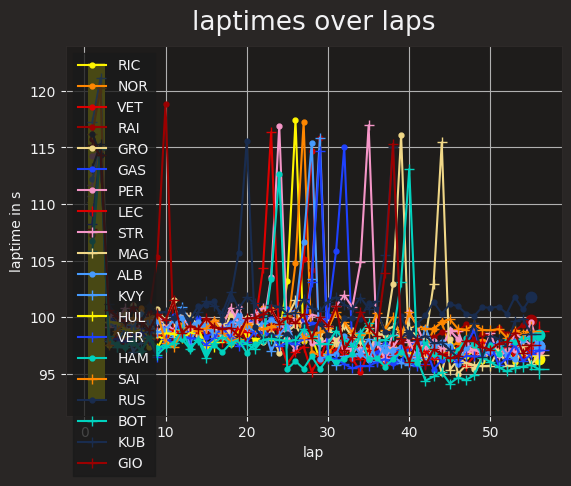

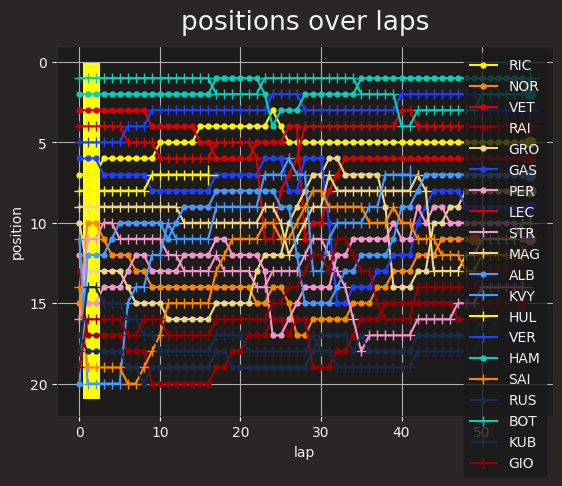

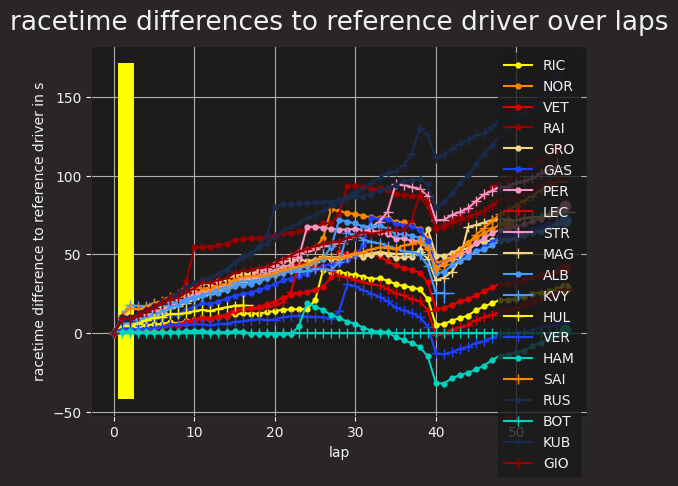

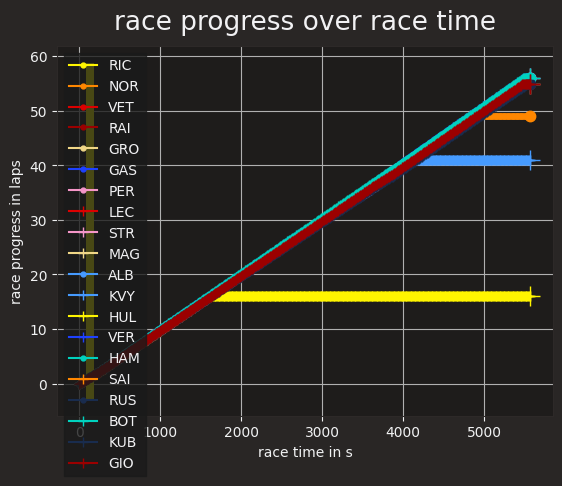

In [56]:
if sim_opts["no_sim_runs"] == 1:
    race_results[0].plot_laptimes()
    race_results[0].plot_positions()
    race_results[0].plot_racetime_diffto_refdriver(1)
    race_results[0].plot_raceprogress_over_racetime()

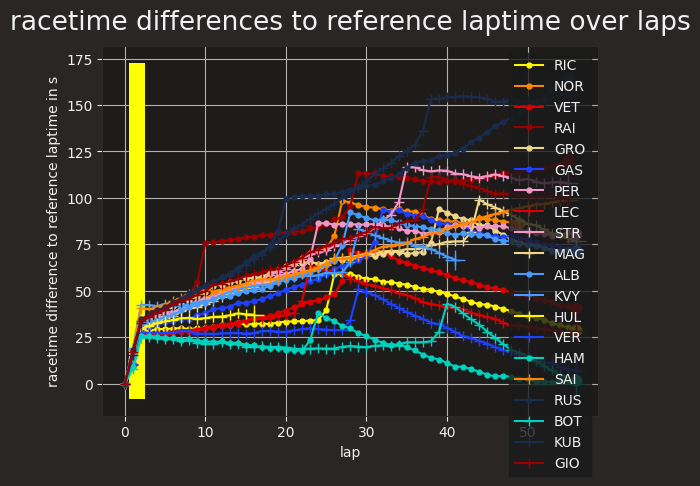

In [57]:
if sim_opts["no_sim_runs"] == 1:
    laps_simulated = race_results[0].cur_lap
    t_race_winner = np.sort(race_results[0].racetimes[laps_simulated, :])[0]
    race_results[0].plot_racetime_diffto_reflaptime(ref_laptime=t_race_winner / laps_simulated)

### Animated simulated race 

core           INFO 	Loading data for Chinese Grand Prix - Race [v3.0.3]
INFO:fastf1.fastf1.core:Loading data for Chinese Grand Prix - Race [v3.0.3]
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
INFO:fastf1.fastf1.req:Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core           INFO 	Processing timing data...
INFO:fastf1.fastf1.core:Processing timing data...
req            INFO 	Using cached data for race_co

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


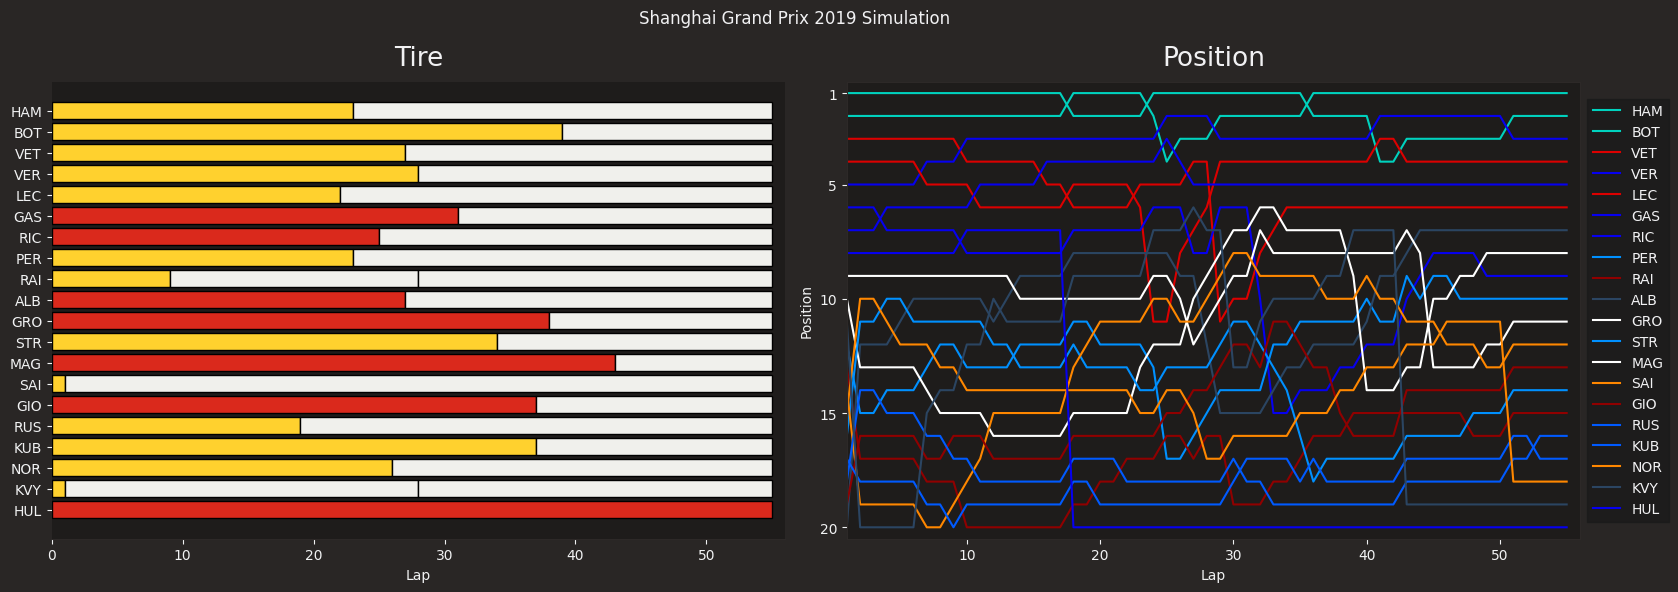

In [58]:
from functools import partial

import fastf1
import pandas as pd
from moviepy.editor import VideoClip

from helper_funcs.src.simulation import make_frame

# settings
FPS = 4.0

# data
session = fastf1.get_session(2019, "Shanghai", "R")
session.load(telemetry=False, weather=False)
drivers = [
    session.get_driver(driver)["Abbreviation"]
    for driver in session.drivers
]
N_LAPS = session.laps["LapNumber"].max()
DURATION = N_LAPS / FPS

# create video
sim = race_results[0].get_race_results()

# make plot
fig, (ax_tire, ax_pos) = plt.subplots(1, 2, figsize=(16.0, 6.0))

# creating animation
animation = VideoClip(
    partial(
        make_frame,
        fps=FPS,
        sim=sim,
        n_laps=N_LAPS,
        ax_tire=ax_tire,
        ax_pos=ax_pos,
        fig=fig,
        drivers=drivers,
        realstrat=realstrategy),
    duration=DURATION)
animation.ipython_display(fps=FPS, loop=True, autoplay=True)

### Race day results

Compared to the actual race results

core           INFO 	Loading data for Chinese Grand Prix - Race [v3.0.3]
INFO:fastf1.fastf1.core:Loading data for Chinese Grand Prix - Race [v3.0.3]
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for timing_data
INFO:fastf1.fastf1.req:Using cached data for timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core           INFO 	Processing timing data...
INFO:fastf1.fastf1.core:Processing timing data...
req            INFO 	Using cached data for race_co

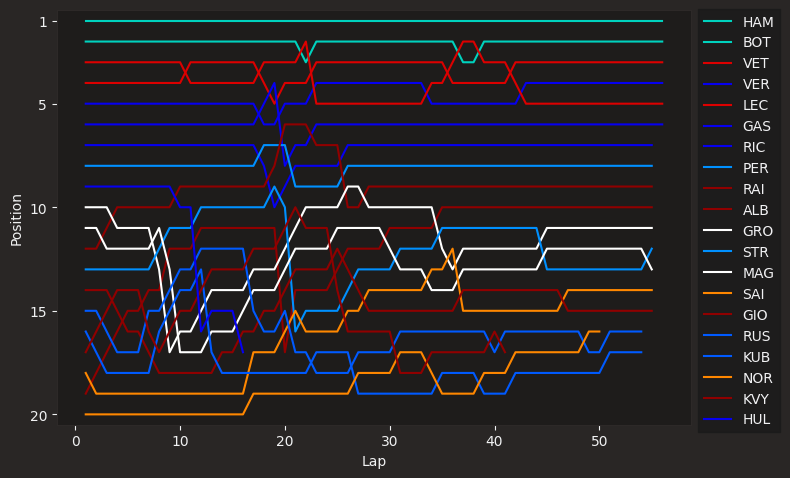

In [59]:
import fastf1.plotting
import matplotlib.pyplot as plt

if sim_opts["no_sim_runs"] == 1:
    session = fastf1.get_session(2019, "Shanghai", "R")
    session.load(telemetry=False, weather=False)

    fig, ax = plt.subplots(figsize=(8.0, 4.9))

    for drv in session.drivers:
        drv_laps = session.laps.pick_driver(drv)

        driver = drv_laps["Driver"].iloc[0]
        team = drv_laps["Team"].iloc[0]

        color = fastf1.plotting.team_color(team)
        ax.plot(drv_laps["LapNumber"], drv_laps["Position"],
                label=driver, color=color)

    ax.set_ylim([20.5, 0.5])
    ax.set_yticks([1, 5, 10, 15, 20])
    ax.set_xlabel("Lap")
    ax.set_ylabel("Position")

    ax.legend(bbox_to_anchor=(1.0, 1.02))
    plt.tight_layout()

    plt.show()

## Run 1000s simulations

In [ ]:
# create list containing the simulated race object (single run) or dicts with valid results (multiple runs)
sim_opts["no_sim_runs"] = NO_SIM_RUN
race_results = []

# save start time for runtime calculation
if sim_opts["use_print"]:
    print("INFO: Starting simulations...")
t_start = time.perf_counter()

# iteration variables
no_sim_runs_left = sim_opts["no_sim_runs"]  # counter for the number of races left for simulation
ctr_invalid = 0                             # counter for the number of simulated races marked as invalid

# SINGLE PROCESS ---------------------------------------------------------------------------------------------------
while no_sim_runs_left > 0:
    # simulate race
    race = race_handle(
        pars_in=pars_in,
        use_prob_infl=sim_opts["use_prob_infl"],
        create_rand_events=sim_opts["create_rand_events"],
        vse_paths=vse_paths)
    no_sim_runs_left -= 1

    # CASE 1: result is valid
    if race.result_status == 0:
        # save race object for later evaluation (single race) or simple race results (MCS)
        if sim_opts["no_sim_runs"] > 1:
            race_results.append(race.get_race_results())
        else:
            race_results.append(race)

    # CASE 2: result is invalid
    else:
        # increase no_sim_runs_left
        ctr_invalid += 1
        no_sim_runs_left += 1

        # pickle race object for further analysis
        if race.result_status >= 10 or race.result_status == -1:
            cur_time_str = time.strftime("%Y%m%d_%H%M%S")
            invalid_race_file = invalid_dir / f"{cur_time_str}_invalid_race_{ctr_invalid}_{race.result_status}.pkl"
            with open(invalid_race_file, "wb") as fh:
                pickle.dump(race, fh)

    # print progressbar
    if sim_opts["use_print"]:
        helper_funcs.src.progressbar.progressbar(
            i=sim_opts["no_sim_runs"] - no_sim_runs_left,
            i_total=sim_opts["no_sim_runs"],
            prefix="INFO: Simulation progress:")

# print number of invalid races
if sim_opts["use_print"]:
    print(f"INFO: There were {ctr_invalid} invalid races!")

# print runtime into console window
if sim_opts["use_print"]:
    runtime = time.perf_counter() - t_start
    print(f"INFO: Simulation runtime: {runtime:.3f}s ({runtime / sim_opts['no_sim_runs'] * 1000:.3f}ms per race)")

INFO: Starting simulations...
INFO: Simulation progress: |██------------------------------------------------| 5.7% 

In [ ]:
len(race_results)

Race results histogram (for multiple races)

In [ ]:
from helper_funcs.src.simulation import race_starting_finish_grid, mcs_analysis

starting_grid, finish_grid = race_starting_finish_grid(2019, "Shanghai")

# For multiple races...
if sim_opts["no_sim_runs"] > 1:
    mcs_analysis(
        race_results=race_results,
        use_print_result=sim_opts["use_print_result"],
        use_plot=True,
        starting_grid=starting_grid,
        finish_grid=finish_grid,
        realstrategy=[])